# Brain MRI Data Exploration Notebook

This notebook processes and analyzes a dataset of brain MRI scans for dementia classification. The dataset contains images across four categories:
- Mild Dementia
- Moderate Dementia
- Non-Demented
- Very Mild Dementia

## Prerequisites
- Python 3.7+
- Required packages: opencv-python, PIL, pandas, numpy, matplotlib, seaborn, scipy
- Dataset structure should be:

        data/

        ├── mild_dementia/

        ├── moderate_dementia/

        ├── non_demented/

        └── very_mild_dementia/

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
from scipy.stats import skew, kurtosis

# Configure paths
PROJECT_PATH = Path.cwd().parent
DATA_DIR = PROJECT_PATH / "data"
CLASSES = ["non_demented", "very_mild_dementia", "mild_dementia", "moderate_dementia"]

## Helper Functions
The following helper functions provide core functionality for image processing:

In [2]:
def safe_load_image(img_path):
    """
    Attempt to load an image with error handling.
    
    Returns:
    • numpy.ndarray or None: Loaded image as grayscale array
    • None if loading fails
    
    Error Handling:
    • Records failed load attempts
    • Provides specific error messages
    • Continues processing on failure
    """
    try:
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError("Image data is None (corrupted or empty file).")
        return img
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

def preprocess_image(img, target_size=(128, 128)):
    """
    Resize and normalize image data.
    
    Parameters:
    • img (numpy.ndarray): Input image
    • target_size (tuple): Desired output dimensions
    
    Returns:
    • numpy.ndarray: Preprocessed image normalized to [0,1]
    """
    resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
    normalized_img = resized_img / 255.0
    return normalized_img

## Dataset Analysis Functions
These functions analyze the distribution and characteristics of the dataset.

In [3]:
def analyze_class_distribution():
    """
    Analyze the existing dataset structure and provide statistics
    
    The function performs the following operations:
    1. Verifies class distributions
    2. Creates visualization of class balance
    3. Calculates percentage distributions
    
    Returns:
    • None, displays plots and prints statistics
    """
    class_counts = {
        "Non Demented": 67222,
        "Very mild Dementia": 13725,
        "Mild Dementia": 5002,
        "Moderate Dementia": 488
    }
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values())
    plt.title("Class Distribution in Dataset")
    plt.xticks(rotation=45)
    plt.ylabel("Number of Images")
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    total = sum(class_counts.values())
    print("\nClass Distribution Percentages:")
    print("-" * 50)
    for cls, count in class_counts.items():
        percentage = (count / total) * 100
        print(f"{cls}: {percentage:.2f}%")
    print("-" * 50)

## Image Statistics Analysis
This section calculates and analyzes basic statistical properties of the images.


In [4]:
def analyze_image_statistics(num_samples=100):
    """
    Analyze basic image statistics across classes.
    
    Operations performed:
    1. Loads sample images from each class
    2. Calculates basic statistical measures
    3. Aggregates results by class
    
    Parameters:
    • num_samples (int): Number of samples per class
    
    Returns:
    • pandas.DataFrame: Statistical measures by class
    """
    stats = {
        'class': [],
        'mean_intensity': [],
        'std_intensity': [],
        'min_intensity': [],
        'max_intensity': []
    }

    for class_name in CLASSES:
        class_dir = DATA_DIR / class_name
        image_files = list(class_dir.glob("*.jpg"))[:num_samples]

        for img_path in image_files:
            img = safe_load_image(img_path)
            if img is None:
                continue

            preprocessed_img = preprocess_image(img)
            stats['class'].append(class_name)
            stats['mean_intensity'].append(np.mean(preprocessed_img))
            stats['std_intensity'].append(np.std(preprocessed_img))
            stats['min_intensity'].append(np.min(preprocessed_img))
            stats['max_intensity'].append(np.max(preprocessed_img))

    return pd.DataFrame(stats)

## Visualization Functions
These functions create visual representations of the data for analysis.

In [5]:
def visualize_sample_images():
    """
    Display sample images and histograms from each class.
    
    Visualization includes:
    1. Original MRI scan
    2. Intensity histogram
    3. Class labels
    
    Layout:
    • 2x4 grid (image + histogram for each class)
    """
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle("Sample Images and Histograms from Each Class", fontsize=16)

    for idx, class_name in enumerate(CLASSES):
        row = idx // 2
        col = idx % 2 * 2

        class_dir = DATA_DIR / class_name
        image_files = list(class_dir.glob("*.jpg"))
        
        img = safe_load_image(np.random.choice(image_files))
        if img is None:
            continue

        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].set_title(f"{class_name} - Sample Image")
        axes[row, col].axis('off')

        axes[row, col + 1].hist(img.ravel(), bins=50, alpha=0.75)
        axes[row, col + 1].set_title(f"{class_name} - Histogram")
        axes[row, col + 1].set_xlabel("Pixel Intensity")
        axes[row, col + 1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

def plot_intensity_distributions():
    """
    Plot normalized intensity distributions by class.
    
    Analysis includes:
    1. Multiple samples per class
    2. Normalized density plots
    3. Overlay visualization
    
    Layout:
    • 2x2 grid (one plot per class)
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle("Pixel Intensity Distributions by Class", fontsize=16)
    
    for idx, class_name in enumerate(CLASSES):
        row, col = divmod(idx, 2)
        class_dir = DATA_DIR / class_name
        image_files = list(class_dir.glob("*.jpg"))
        sample_imgs = [safe_load_image(f) for f in np.random.choice(image_files, 5) if f]
        
        for img in sample_imgs:
            if img is not None:
                axes[row, col].hist(img.ravel(), bins=50, alpha=0.3, density=True)
        
        axes[row, col].set_title(f"{class_name}")
        axes[row, col].set_xlabel("Pixel Intensity")
        axes[row, col].set_ylabel("Density")
    
    plt.tight_layout()
    plt.show()

## Statistical Analysis Functions
These functions perform detailed statistical analysis of the image data.

In [6]:
def analyze_central_moments(num_samples=5):
    """
    Calculate and analyze central moments of image distributions.
    
    Metrics calculated:
    1. Mean
    2. Variance
    3. Skewness
    4. Kurtosis
    
    Parameters:
    • num_samples (int): Samples per class
    
    Returns:
    • pandas.DataFrame: Mean moments by class
    """
    moments = {
        'class': [], 
        'mean': [], 
        'variance': [], 
        'skewness': [], 
        'kurtosis': []
    }

    for class_name in CLASSES:
        class_dir = DATA_DIR / class_name
        image_files = list(class_dir.glob("*.jpg"))[:num_samples]

        for img_path in image_files:
            img = safe_load_image(img_path)
            if img is None:
                continue

            flat_img = img.ravel()
            moments['class'].append(class_name)
            moments['mean'].append(np.mean(flat_img))
            moments['variance'].append(np.var(flat_img))
            moments['skewness'].append(skew(flat_img))
            moments['kurtosis'].append(kurtosis(flat_img))

    moments_df = pd.DataFrame(moments)
    return moments_df.groupby('class').mean()

## Execution Section
Main execution pipeline that runs all analyses in sequence.

Starting analysis pipeline...

1. Analyzing Class Distribution
--------------------------------------------------


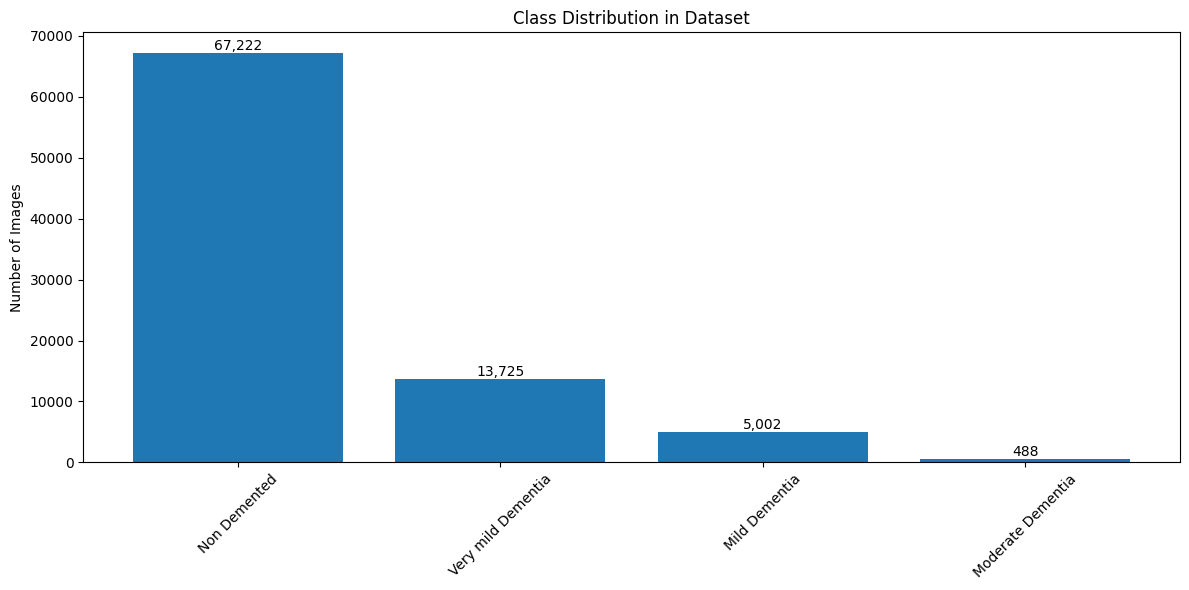


Class Distribution Percentages:
--------------------------------------------------
Non Demented: 77.77%
Very mild Dementia: 15.88%
Mild Dementia: 5.79%
Moderate Dementia: 0.56%
--------------------------------------------------

2. Basic Image Statistics
--------------------------------------------------
                    mean_intensity  std_intensity  min_intensity  \
class                                                              
mild_dementia             0.157625       0.172206            0.0   
moderate_dementia         0.156390       0.172665            0.0   
non_demented              0.167343       0.172870            0.0   
very_mild_dementia        0.154154       0.170954            0.0   

                    max_intensity  
class                              
mild_dementia            0.896824  
moderate_dementia        0.890549  
non_demented             0.877098  
very_mild_dementia       0.887098  

3. Visualizing Sample Images
--------------------------------------

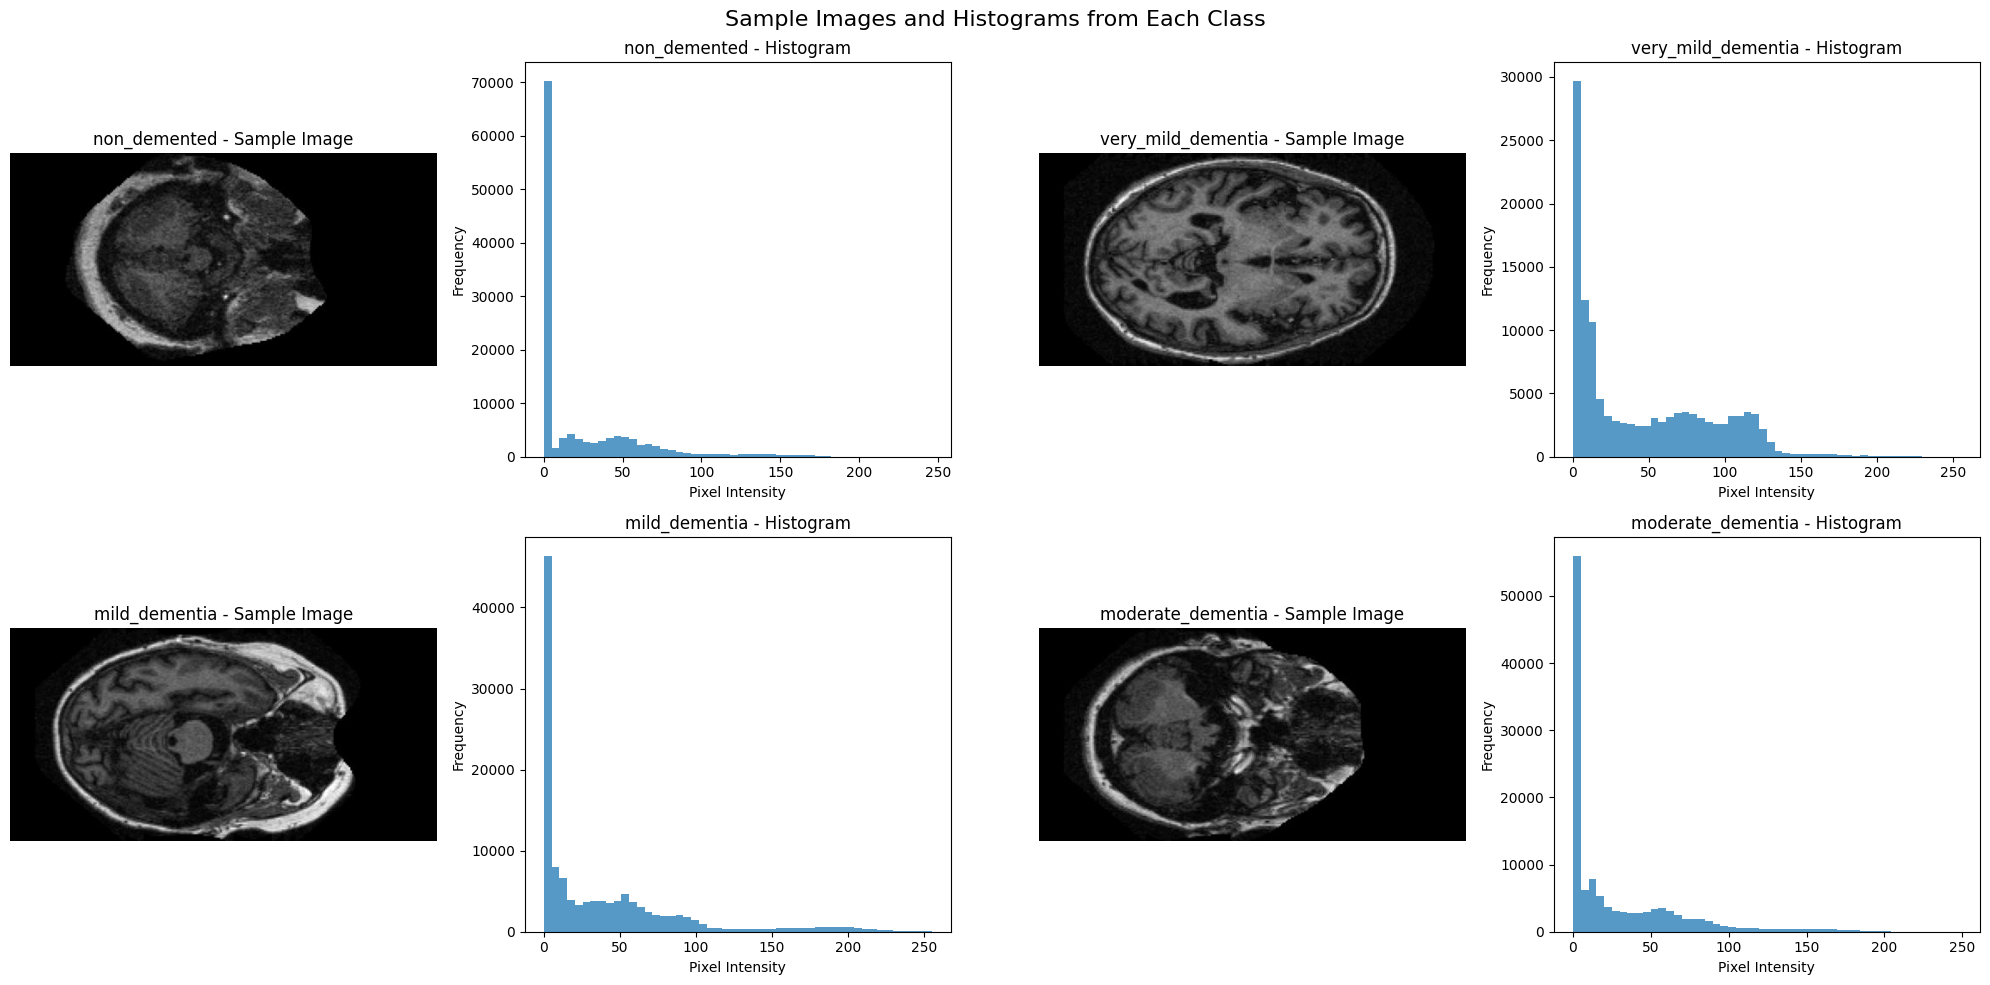

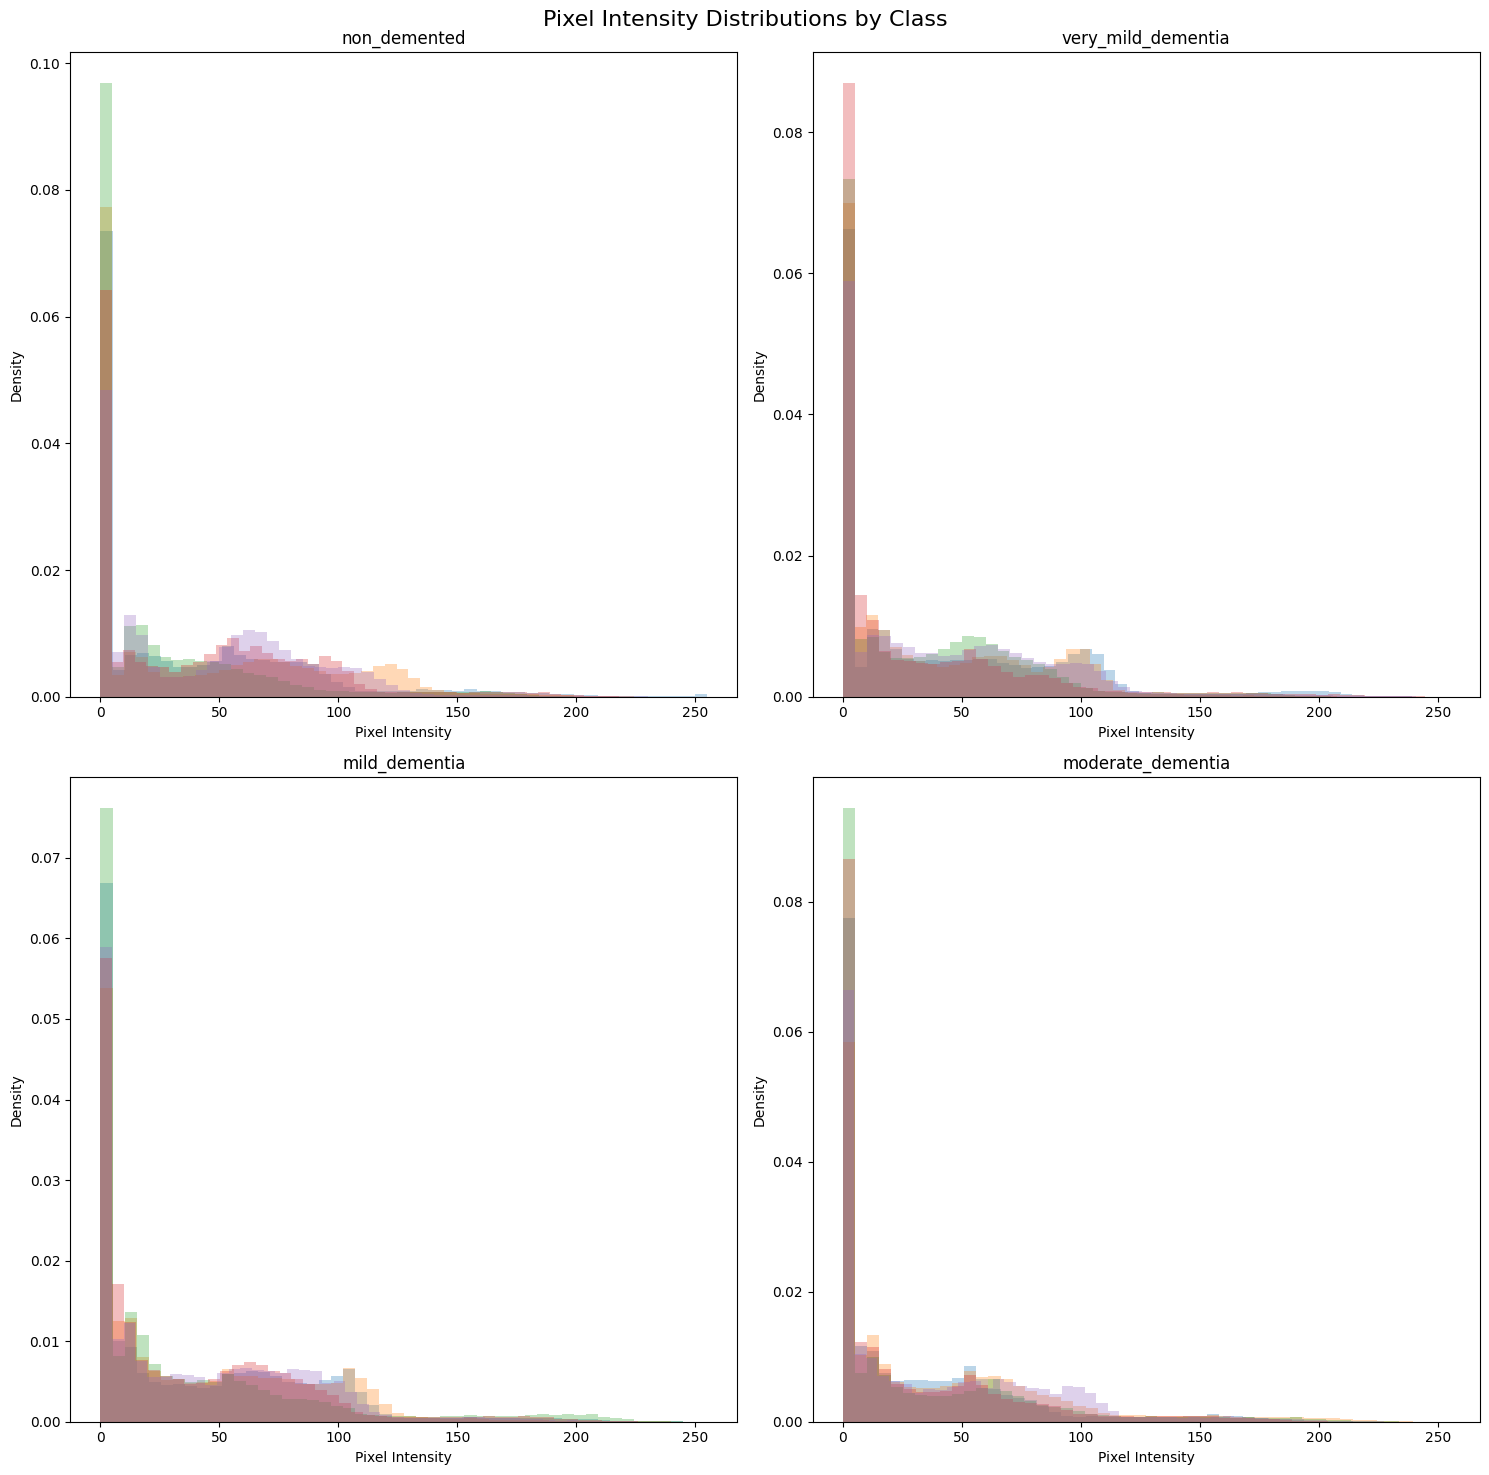


4. Statistical Moments Analysis
--------------------------------------------------

Central Moments by Class:
                         mean     variance  skewness  kurtosis
class                                                         
mild_dementia       40.831889  2027.324127  1.162771  1.019807
moderate_dementia   38.403527  2085.402552  1.436517  1.839780
non_demented        46.680348  2146.139803  0.726771 -0.220668
very_mild_dementia  35.339022  1969.636981  1.419201  1.882626

Key Findings:
--------------------------------------------------
1. Class Imbalance: Dataset shows significant imbalance
2. Image Quality: Preprocessing normalizes to [0,1] range
3. Intensity Distribution: Varies across classes
4. Recommendations:
   • Consider oversampling or data augmentation
   • Implement class weights in model
   • Monitor class-wise performance metrics


In [7]:
def main():
    """
    Execute the complete analysis pipeline.
    
    Process Flow:
    1. Dataset analysis
    2. Statistical analysis
    3. Visualization generation
    4. Results summary
    
    Outputs:
    • Class distribution statistics
    • Image statistics summary
    • Visualizations
    • Key findings
    """
    print("Starting analysis pipeline...")
    print("\n1. Analyzing Class Distribution")
    print("-" * 50)
    analyze_class_distribution()

    print("\n2. Basic Image Statistics")
    print("-" * 50)
    stats_df = analyze_image_statistics()
    print(stats_df.groupby('class').mean())

    print("\n3. Visualizing Sample Images")
    print("-" * 50)
    visualize_sample_images()
    plot_intensity_distributions()

    print("\n4. Statistical Moments Analysis")
    print("-" * 50)
    moments_summary = analyze_central_moments()
    print("\nCentral Moments by Class:")
    print(moments_summary)

    print("\nKey Findings:")
    print("-" * 50)
    print("1. Class Imbalance: Dataset shows significant imbalance")
    print("2. Image Quality: Preprocessing normalizes to [0,1] range")
    print("3. Intensity Distribution: Varies across classes")
    print("4. Recommendations:")
    print("   • Consider oversampling or data augmentation")
    print("   • Implement class weights in model")
    print("   • Monitor class-wise performance metrics")

if __name__ == "__main__":
    main()